Overview of Deep learning in Quantitative Finance with Pytorch

Simulate a Delta hedge of a Black-Scholes model

dx/x = sigma dW

For a call option over one time step

In [1]:
import torch

class LSTM(torch.nn.Module):
    def __init__(self, input_size=1, batch_size=10, hidden_layer_size=256, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.batch_size = batch_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = torch.nn.Linear(hidden_layer_size, output_size)

        self.init_hidden()

    def init_hidden(self):
        self.hidden_cell = (torch.zeros(1,self.batch_size,self.hidden_layer_size),
                            torch.zeros(1,self.batch_size,self.hidden_layer_size))


    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions

def entropy_loss(x,d=20):
    return 1./d*torch.log(torch.mean(torch.exp(-d*x)))

In [2]:
batch_size = 4000

epochs = 10
training_size = 50
seq_len = 1
input_dim = 1
risk_aversion = 20
sigma = 0.2

In [3]:
model = LSTM(batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [4]:
for i in range(epochs):
    for j in range(training_size):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, model.batch_size, model.hidden_layer_size),
                        torch.zeros(1, model.batch_size, model.hidden_layer_size))

        # Initial model price is 0
        x0 = torch.zeros(batch_size, seq_len + 1, input_dim)

        # One step simulation
        dx = torch.randn(batch_size, seq_len, input_dim)

        for k in range(seq_len):
            x0[:,k+1,:] = x0[:,k,:] + sigma * dx[:,k,:]

        delta = model(x0[:,:-1,:])

        # Payoff being pi = max(dx-0,0)
        payoff = torch.max(x0[:,-1,:],torch.tensor(0.))

        # Hedge performance pnl = pi - delta * dx
            
        pnl = torch.zeros(batch_size, input_dim)
        delta_zero = torch.zeros(batch_size, input_dim)

        for k in range(seq_len):
            pnl = pnl + (delta[:,k,:]-delta_zero)  * x0[:,k,:]
            delta_zero = delta[:,k,:]

        pnl = pnl + payoff - delta[:,-1,:]*x0[:,-1,:]

        # Loss function is a mean variance optimisation
        loss = -torch.mean(pnl) + risk_aversion * torch.norm(pnl)

        # Propagate derivates
        loss.backward()
        # Optimize
        optimizer.step()
    # Print some deltas
    print(delta[0:5,:,0])

    print(f'Epoch number: {i:3} mean variance loss: {loss.item():10.6f}')


tensor([[0.0188],
        [0.0188],
        [0.0188],
        [0.0188],
        [0.0188]], grad_fn=<SelectBackward>)
Epoch number:   0 mean variance loss: 177.812363
tensor([[0.0601],
        [0.0601],
        [0.0601],
        [0.0601],
        [0.0601]], grad_fn=<SelectBackward>)
Epoch number:   1 mean variance loss: 167.152588
tensor([[0.1080],
        [0.1080],
        [0.1080],
        [0.1080],
        [0.1080]], grad_fn=<SelectBackward>)
Epoch number:   2 mean variance loss: 160.692184
tensor([[0.1638],
        [0.1638],
        [0.1638],
        [0.1638],
        [0.1638]], grad_fn=<SelectBackward>)
Epoch number:   3 mean variance loss: 152.573868
tensor([[0.2273],
        [0.2273],
        [0.2273],
        [0.2273],
        [0.2273]], grad_fn=<SelectBackward>)
Epoch number:   4 mean variance loss: 144.746414
tensor([[0.2940],
        [0.2940],
        [0.2940],
        [0.2940],
        [0.2940]], grad_fn=<SelectBackward>)
Epoch number:   5 mean variance loss: 135.626495
tens

In [5]:
idx = 0
x_plot = x0[:,idx,0].detach().numpy()
delta_plot = delta[:,idx,0].detach().numpy()
pnl_plot = pnl[:,0].detach().numpy()
payoff_plot = payoff[:,0].detach().numpy()

In [6]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt

In [7]:
import pandas as pd

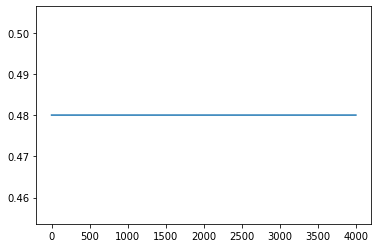

In [8]:
plt.plot(delta_plot)

(array([[7.520e+02, 7.170e+02, 5.940e+02, 5.320e+02, 4.330e+02, 3.510e+02,
         2.200e+02, 1.520e+02, 1.000e+02, 6.500e+01, 4.200e+01, 1.900e+01,
         1.300e+01, 7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [2.191e+03, 1.790e+02, 1.720e+02, 1.800e+02, 1.490e+02, 1.450e+02,
         1.340e+02, 1.370e+02, 1.300e+02, 1.020e+02, 8.400e+01, 7.500e+01,
         6.700e+01, 4.900e+01, 4.000e+01, 3.600e+01, 2.600e+01, 2.800e+01,
         1.200e+01, 1.100e+01, 1.800e+01, 1.000e+01, 5.000e+00, 3.000e+00,
         8.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]]),
 array([0.        , 0.02347578, 0.04695156, 0.07042734, 0.09390312,
        0.1173789 , 0.14085469, 0.16433047, 0.18780623, 0.21128201,
        0.2347578 , 0.25823358, 0.28170937, 0.30518514, 0.32866094,
        0.3521367 , 0.37561247, 0.39908826

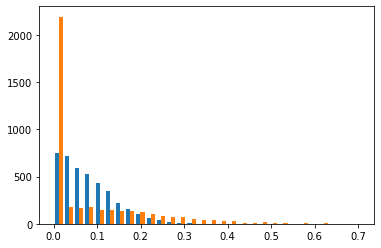

In [9]:
plt.hist([pnl_plot,payoff_plot],bins=30)